# SPICAV Exploratory Data Analysis

## This notebook explores the SPICAV dataset from Venus Express satellite

## Author: g.mahapatra@tudelft.nl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import read_spicav_ir as rd     # This is a utility library to read SPICAV data written by Loic Rossi, LATMOS.
import pymiedap.pymiedap as pmd # This is a Python library to perform RT related computations.
import pandas as pd
from scipy import interpolate

In [3]:
# set the path to SPICAV data
path = '/Users/gouravmahapatr/Dropbox/PhD/spicav_data'

### Make a function to build the geometry dataframe

In [4]:
# read the data
def make_orbitdatadf(orbitnum,orbittype):
    data = rd.processing_orbits(orbitnum,orbittype)   # data is an object
    # calculate the azimuth
    data.geo.calc_azimuth()
    # calculate the beta (rotation angle)
    cosbeta = pmd.get_cosbeta(np.array(data.geo.phase),np.array(data.geo.sza),np.array(data.geo.emission),np.array(data.geo.azimuth)) # in radians
    beta = np.degrees(np.arccos(cosbeta)) # Converted into degrees
    # get the localtime
    localtime = data.geo.local_time     
    # make a dataframe
    orbitdatadf = pd.DataFrame(localtime,columns=['localtime'])
    orbitdatadf['lat'] = data.geo.Lat
    orbitdatadf['lon'] = data.geo.Lon
    orbitdatadf['phase'] = data.geo.phase
    orbitdatadf['sza'] = data.geo.sza
    orbitdatadf['emission'] = data.geo.emission
    orbitdatadf['azimuth'] = data.geo.azimuth
    orbitdatadf['beta'] = beta
    orbitdatadf['orbitnum'] = orbitnum
    orbitdatadf['orbittype'] = orbittype
    orbitdatadf['ObsvSeq'] = np.arange(len(data.geo.local_time))
    return orbitdatadf

# call
orbitdatadf = make_orbitdatadf(100,2)
orbitdatadf = pd.concat([orbitdatadf,make_orbitdatadf(400,10)],ignore_index=True)
orbitdatadf

/Users/gouravmahapatr/Dropbox/PhD/spicav_data/calibrated_data2013/SPIV_0BR_0100A02_N_05_calibr_2013_polar_virtis.DAT
nbl = 2
fnb = 859


/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsorptionRetrival/src/read_spicav_ir.py:318: RuntimeWarning: invalid value encountered in less
  r0_invalid = (radf_d0<0)  # identification of negative radiance values
/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsorptionRetrival/src/read_spicav_ir.py:319: RuntimeWarning: invalid value encountered in less
  r1_invalid = (radf_d1<0)
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 file(s) have been read
/Users/gouravmahapatr/Dropbox/PhD/spicav_data/calibrated_data2013/SPIV_0BR_0400A10_N_05_calibr_2013_polar_virtis.DAT
nbl = 4
fnb = 430


/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsorptionRetrival/src/read_spicav_ir.py:175: RuntimeWarning: invalid value encountered in arccos
  delta_phi = np.degrees(np.arccos(c_delta_phi))


1 file(s) have been read


,localtime,lat,lon,phase,sza,emission,azimuth,beta,orbitnum,orbittype,ObsvSeq
0,21.277778,41.1324,264.6631,125.14,125.16,0.02,NaN,180.000000,100,2,0
1,21.277778,41.2371,264.6633,125.07,125.09,0.02,0.000051,180.000000,100,2,1
2,21.277778,41.3421,264.6636,125.01,125.03,0.02,0.000025,180.000000,100,2,2
3,21.277778,41.4472,264.6638,124.95,124.97,0.02,0.000023,180.000000,100,2,3
4,21.277778,41.5524,264.6641,124.88,124.90,0.02,NaN,180.000000,100,2,4
...,...,...,...,...,...,...,...,...,...,...,...
1284,15.652222,-33.0621,196.2390,91.56,59.93,31.63,NaN,0.000000,400,10,425
1285,15.649444,-33.0830,196.2800,91.56,59.90,31.66,NaN,0.000000,400,10,426
1286,15.646667,-33.1039,196.3210,91.56,59.88,31.68,NaN,0.000000,400,10,427
1287,15.643889,-33.1247,196.3619,91.56,59.85,31.71,NaN,0.000000,400,10,428


### Get the orbits list that are within the orbit range 

In [5]:
# get the orbits list that are within a certain orbit range
orbit_list = rd.find_orbits(400,1500)        # this is a function from read_spicav_ir
orbit_listdf = pd.DataFrame(orbit_list,columns=['Orbit Number','Type'])
orbit_listdf

,Orbit Number,Type
0,400,10
1,400,11
2,401,9
3,401,10
4,402,7
...,...,...
524,1483,7
525,1485,7
526,1488,7
527,1489,7


###  Make a dataframe combining all the orbits found in orbit_list

In [6]:
reload = False
if reload:
    # call the make_orbitdatadf function on first item from the list
    orbitdatadf = make_orbitdatadf(orbit_list[0,0],orbit_list[0,1])

    # iterate through the rest of the orbit list while concatenating the data
    for i in range(len(orbit_list)):
        orbit_n = orbit_list[i,0]
        orbit_a = orbit_list[i,1]
        orbitdatadf = pd.concat([orbitdatadf,make_orbitdatadf(orbit_n,orbit_a)],ignore_index=True)
    orbitdatadf.to_csv('../outputs/orbitdata.csv',index=False)
else:
    orbitdatadf = pd.read_csv('../outputs/orbitdata.csv')  # or just load the saved dataframe

# calculate the beta (rotation angle)
cosbeta = pmd.get_cosbeta(np.array(orbitdatadf['phase']),np.array(orbitdatadf['sza']),np.array(orbitdatadf['emission']),np.array(orbitdatadf['azimuth'])) # in radians
beta = np.degrees(np.arccos(cosbeta)) # Converted into degrees
orbitdatadf['beta'] = beta

orbitdatadf

/Users/gouravmahapatr/lib/python/PyMieDAP-0.1-py3.7-macosx-10.7-x86_64.egg/pymiedap/pymiedap.py:854: RuntimeWarning: divide by zero encountered in true_divide
  cb = num/denom
/Users/gouravmahapatr/lib/python/PyMieDAP-0.1-py3.7-macosx-10.7-x86_64.egg/pymiedap/pymiedap.py:854: RuntimeWarning: invalid value encountered in true_divide
  cb = num/denom


,localtime,lat,lon,phase,sza,emission,azimuth,beta,orbitnum,orbittype,ObsvSeq
0,16.731389,-13.9887,179.9898,90.82,71.09,19.73,179.999999,8.537736e-07,400,10,0
1,16.729167,-14.0694,180.0232,90.82,71.06,19.76,179.999998,1.707547e-06,400,10,1
2,16.726944,-14.1499,180.0567,90.82,71.03,19.79,NaN,0.000000e+00,400,10,2
3,16.724722,-14.2302,180.0902,90.82,71.00,19.82,NaN,8.537736e-07,400,10,3
4,16.722500,-14.3101,180.1237,90.82,70.98,19.85,178.110673,1.786327e+00,400,10,4
...,...,...,...,...,...,...,...,...,...,...,...
263290,14.307500,15.3176,339.6980,29.18,38.66,11.00,26.609677,1.449773e+02,1491,8,541
263291,14.308056,15.2363,339.6896,29.14,38.64,11.01,26.498935,1.450996e+02,1491,8,542
263292,14.308611,15.1551,339.6812,29.11,38.61,11.02,26.569558,1.449893e+02,1491,8,543
263293,14.309444,15.0740,339.6728,29.07,38.58,11.03,26.548804,1.449944e+02,1491,8,544


### Implement a filter 

In [7]:
def filter_data(orbitdatadf,fields=list([[None,None,None]])):
    '''
    This function implements a filter on the dataframe. 
    The fields list stores lists containing [fieldname,minval,maxval]
    '''
    for fieldlist in fields:
        if fieldlist[0] == None:
            pass
        else:
            orbitdatadf = orbitdatadf[(orbitdatadf[fieldlist[0]]>=fieldlist[1])&(orbitdatadf[fieldlist[0]]<=fieldlist[2])]
    return orbitdatadf

fields=list([['localtime',6,18],['lat',-60,60]])
#print(fields[1])
orbitdatadf_filtered = filter_data(orbitdatadf,fields=fields)
orbitdatadf_filtered

,localtime,lat,lon,phase,sza,emission,azimuth,beta,orbitnum,orbittype,ObsvSeq
0,16.731389,-13.9887,179.9898,90.82,71.09,19.73,179.999999,8.537736e-07,400,10,0
1,16.729167,-14.0694,180.0232,90.82,71.06,19.76,179.999998,1.707547e-06,400,10,1
2,16.726944,-14.1499,180.0567,90.82,71.03,19.79,NaN,0.000000e+00,400,10,2
3,16.724722,-14.2302,180.0902,90.82,71.00,19.82,NaN,8.537736e-07,400,10,3
4,16.722500,-14.3101,180.1237,90.82,70.98,19.85,178.110673,1.786327e+00,400,10,4
...,...,...,...,...,...,...,...,...,...,...,...
263290,14.307500,15.3176,339.6980,29.18,38.66,11.00,26.609677,1.449773e+02,1491,8,541
263291,14.308056,15.2363,339.6896,29.14,38.64,11.01,26.498935,1.450996e+02,1491,8,542
263292,14.308611,15.1551,339.6812,29.11,38.61,11.02,26.569558,1.449893e+02,1491,8,543
263293,14.309444,15.0740,339.6728,29.07,38.58,11.03,26.548804,1.449944e+02,1491,8,544


### Make scatter plots for different geometries

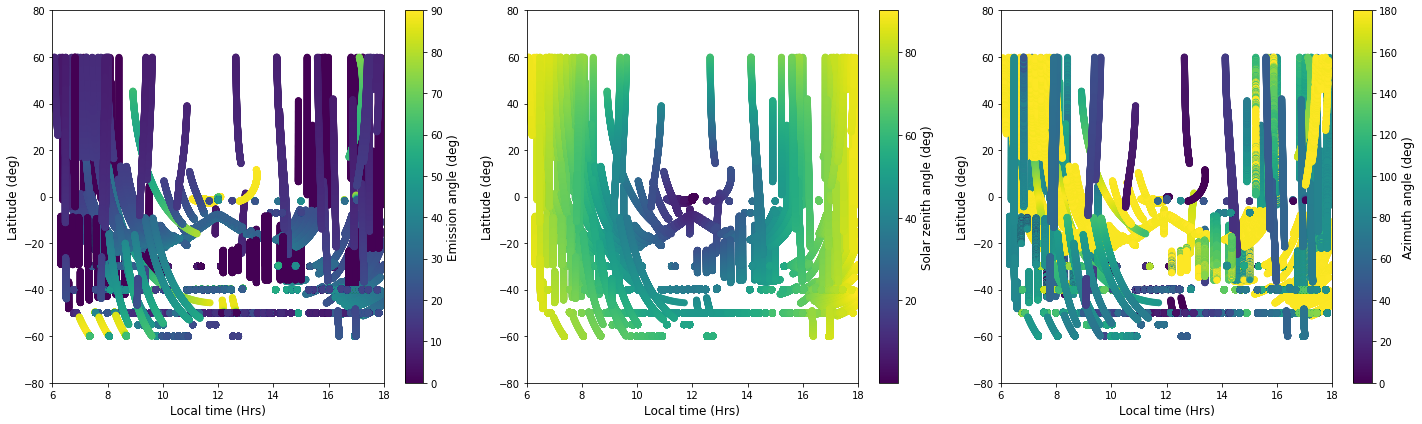

In [8]:
# make plots
#os.chdir('../figures/')
%matplotlib inline
#%matplotlib notebook
plt.figure(figsize=[20,6])
plt.subplot(131)
plt.scatter(orbitdatadf_filtered['localtime'],orbitdatadf_filtered['lat'],c=orbitdatadf_filtered['emission'])
plt.xlim([6,18])
plt.ylim([-80,80])
clb = plt.colorbar()
clb.set_label('Emission angle (deg)',fontsize='large')
plt.xlabel('Local time (Hrs)',fontsize='large')
plt.ylabel('Latitude (deg)',fontsize='large')
#plt.tight_layout()
#plt.savefig('emission_plot_400to1500.pdf')
#plt.close()

plt.subplot(132)
plt.scatter(orbitdatadf_filtered['localtime'],orbitdatadf_filtered['lat'],c=orbitdatadf_filtered['sza'])
plt.xlim([6,18])
plt.ylim([-80,80])
clb = plt.colorbar()
clb.set_label('Solar zenith angle (deg)',fontsize='large')
plt.xlabel('Local time (Hrs)',fontsize='large')
plt.ylabel('Latitude (deg)',fontsize='large')
#plt.tight_layout()
#plt.savefig('sza_plot_400to1500.pdf')
#plt.close()

plt.subplot(133)
plt.scatter(orbitdatadf_filtered['localtime'],orbitdatadf_filtered['lat'],c=orbitdatadf_filtered['azimuth'])
plt.xlim([6,18])
plt.ylim([-80,80])
clb = plt.colorbar()
clb.set_label('Azimuth angle (deg)',fontsize='large')
plt.xlabel('Local time (Hrs)',fontsize='large')
plt.ylabel('Latitude (deg)',fontsize='large')
plt.tight_layout()
#plt.savefig('../outputs/geometryScatter.png')

### Make histograms to understand the range of values in geometry file 

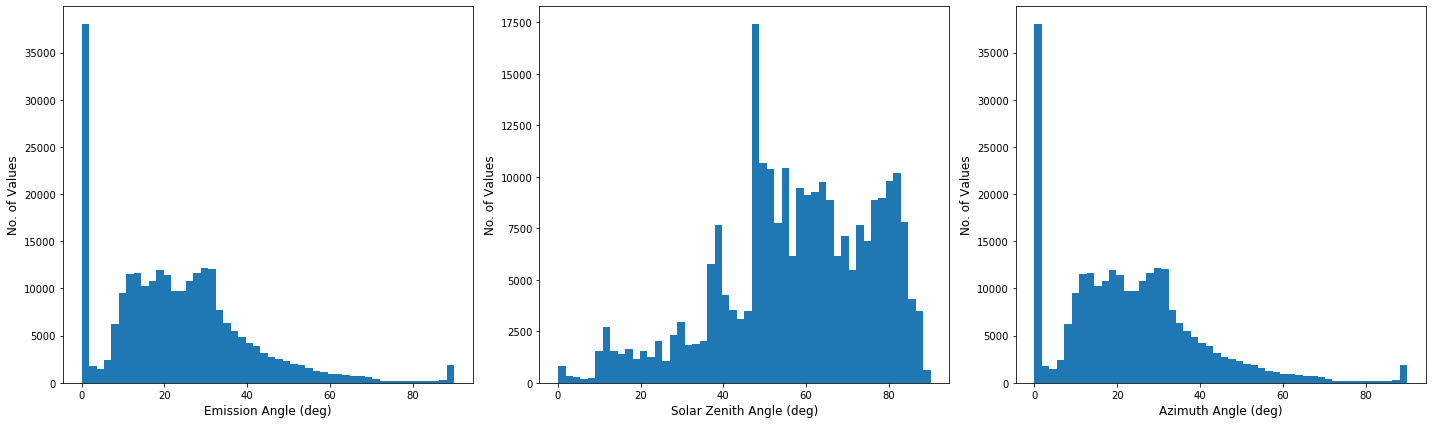

In [9]:
plt.figure(figsize=[20,6])
plt.subplot(131)
_ = plt.hist(orbitdatadf_filtered['emission'],bins=50)
plt.xlabel('Emission Angle (deg)',fontsize='large')
plt.ylabel('No. of Values',fontsize='large')
plt.subplot(132)
_ = plt.hist(orbitdatadf_filtered['sza'],bins=50)
plt.xlabel('Solar Zenith Angle (deg)',fontsize='large')
plt.ylabel('No. of Values',fontsize='large')
plt.subplot(133)
_ = plt.hist(orbitdatadf_filtered['emission'],bins=50)
plt.xlabel('Azimuth Angle (deg)',fontsize='large')
plt.ylabel('No. of Values',fontsize='large')
plt.tight_layout()
plt.savefig('../outputs/GeometryHistPlot.pdf')

### Filter the data further to only have geometries with Emission < 1 deg. 

In [10]:
fields=list([['emission',0,1]])#,['azimuth',0,1]])
#print(fields[1])
orbitdatadf_filtered2 = filter_data(orbitdatadf_filtered,fields=fields)
orbitdatadf_filtered2

,localtime,lat,lon,phase,sza,emission,azimuth,beta,orbitnum,orbittype,ObsvSeq
6121,15.412778,-12.1234,127.9919,52.99,52.95,0.11,111.285025,68.637675,494,14,0
6122,15.412778,-12.0694,127.9920,52.97,52.93,0.11,111.284997,68.637646,494,14,1
6123,15.412778,-12.0153,127.9921,52.96,52.92,0.11,111.284983,68.637632,494,14,2
6124,15.412778,-11.9611,127.9922,52.95,52.91,0.11,111.284969,68.637618,494,14,3
6125,15.412778,-11.9067,127.9923,52.94,52.90,0.11,111.284955,68.637604,494,14,4
...,...,...,...,...,...,...,...,...,...,...,...
262744,13.808333,-29.2142,341.0609,37.15,37.07,0.11,136.608315,43.291895,1489,7,842
262745,13.808333,-29.2308,341.0610,37.16,37.08,0.11,136.608333,43.291913,1489,7,843
262746,13.808333,-29.2475,341.0610,37.18,37.09,0.11,144.861409,35.055071,1489,7,844
262747,13.808333,-29.2641,341.0610,37.19,37.10,0.11,144.861424,35.055086,1489,7,845


### Make another histogram with the updated values 

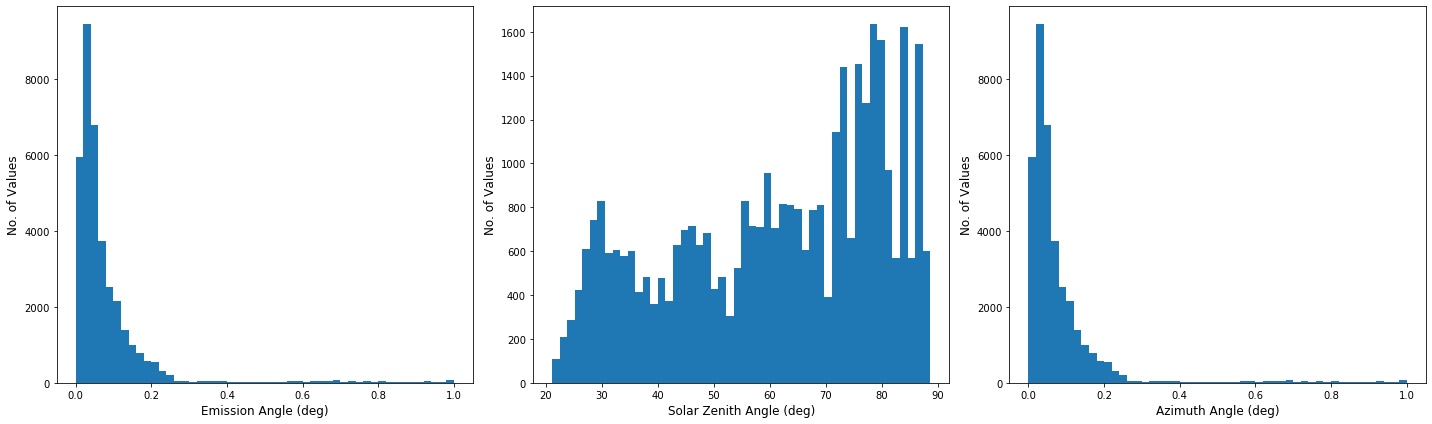

In [11]:
plt.figure(figsize=[20,6])
plt.subplot(131)
_ = plt.hist(orbitdatadf_filtered2['emission'],bins=50)
plt.xlabel('Emission Angle (deg)',fontsize='large')
plt.ylabel('No. of Values',fontsize='large')
plt.subplot(132)
_ = plt.hist(orbitdatadf_filtered2['sza'],bins=50)
plt.xlabel('Solar Zenith Angle (deg)',fontsize='large')
plt.ylabel('No. of Values',fontsize='large')
plt.subplot(133)
_ = plt.hist(orbitdatadf_filtered2['emission'],bins=50)
plt.xlabel('Azimuth Angle (deg)',fontsize='large')
plt.ylabel('No. of Values',fontsize='large')
plt.tight_layout()
#plt.savefig('../outputs/GeometryHistPlot2.pdf')

### Make another scatter plot to see where the data with emi = 0 lies... 

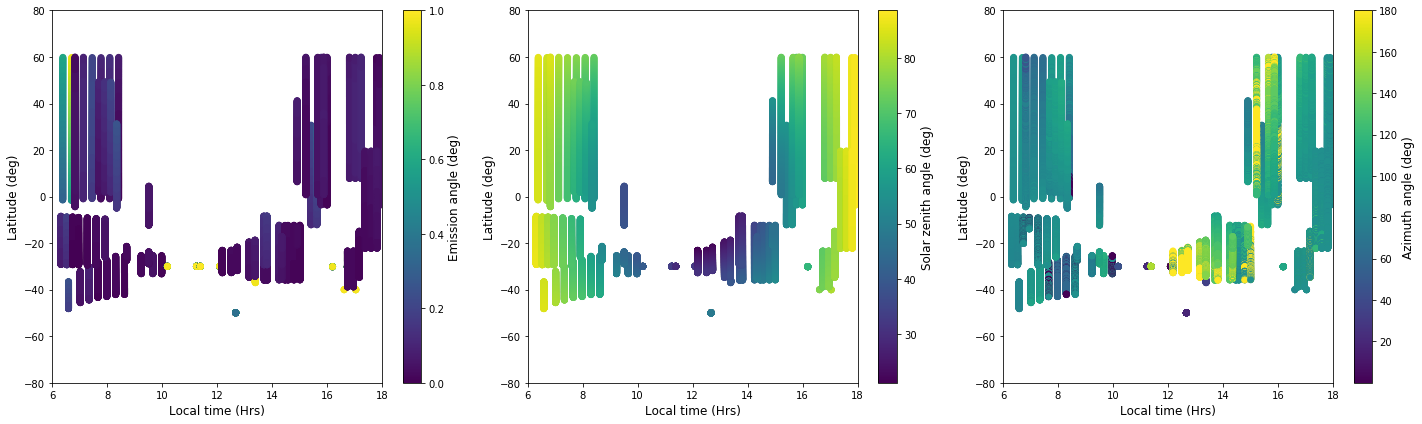

In [12]:
%matplotlib inline
#%matplotlib notebook
plt.figure(figsize=[20,6])
plt.subplot(131)
plt.scatter(orbitdatadf_filtered2['localtime'],orbitdatadf_filtered2['lat'],c=orbitdatadf_filtered2['emission'])
plt.xlim([6,18])
plt.ylim([-80,80])
clb = plt.colorbar()
clb.set_label('Emission angle (deg)',fontsize='large')
plt.xlabel('Local time (Hrs)',fontsize='large')
plt.ylabel('Latitude (deg)',fontsize='large')
#plt.tight_layout()
#plt.savefig('emission_plot_400to1500.pdf')
#plt.close()

plt.subplot(132)
plt.scatter(orbitdatadf_filtered2['localtime'],orbitdatadf_filtered2['lat'],c=orbitdatadf_filtered2['sza'])
plt.xlim([6,18])
plt.ylim([-80,80])
clb = plt.colorbar()
clb.set_label('Solar zenith angle (deg)',fontsize='large')
plt.xlabel('Local time (Hrs)',fontsize='large')
plt.ylabel('Latitude (deg)',fontsize='large')
#plt.tight_layout()
#plt.savefig('sza_plot_400to1500.pdf')
#plt.close()

plt.subplot(133)
plt.scatter(orbitdatadf_filtered2['localtime'],orbitdatadf_filtered2['lat'],c=orbitdatadf_filtered2['azimuth'])
plt.xlim([6,18])
plt.ylim([-80,80])
clb = plt.colorbar()
clb.set_label('Azimuth angle (deg)',fontsize='large')
plt.xlabel('Local time (Hrs)',fontsize='large')
plt.ylabel('Latitude (deg)',fontsize='large')
plt.tight_layout()
#plt.savefig('../outputs/geometryScatter2.png')

### Make a DataFrame with all the flux and polarization data 

In [13]:
# Geometries dataframe
orbitdatadf_filtered_emi = orbitdatadf_filtered2.copy()
orbitdatadf_filtered_emi.reset_index(inplace=True)
#orbitdatadf_filtered_emi.rename(columns={"index":"originalindex"})
orbitdatadf_filtered_emi

,index,localtime,lat,lon,phase,sza,emission,azimuth,beta,orbitnum,orbittype,ObsvSeq
0,6121,15.412778,-12.1234,127.9919,52.99,52.95,0.11,111.285025,68.637675,494,14,0
1,6122,15.412778,-12.0694,127.9920,52.97,52.93,0.11,111.284997,68.637646,494,14,1
2,6123,15.412778,-12.0153,127.9921,52.96,52.92,0.11,111.284983,68.637632,494,14,2
3,6124,15.412778,-11.9611,127.9922,52.95,52.91,0.11,111.284969,68.637618,494,14,3
4,6125,15.412778,-11.9067,127.9923,52.94,52.90,0.11,111.284955,68.637604,494,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...
36750,262744,13.808333,-29.2142,341.0609,37.15,37.07,0.11,136.608315,43.291895,1489,7,842
36751,262745,13.808333,-29.2308,341.0610,37.16,37.08,0.11,136.608333,43.291913,1489,7,843
36752,262746,13.808333,-29.2475,341.0610,37.18,37.09,0.11,144.861409,35.055071,1489,7,844
36753,262747,13.808333,-29.2641,341.0610,37.19,37.10,0.11,144.861424,35.055086,1489,7,845


In [14]:
def calc_SPICAV_pol(r0,r1):
    '''
    Function to calculate the degree of polarization using two flux channels of SPICAV dataset.   
    Polarization is calculated as (det1 - det0)/(det0 + det1).
    It requires two orthogonal channels of SPICAV flux data. 
    '''
    # enforce that the lengths of two arrays are equal. 
    if r0.shape == r1.shape:
        pol = np.nan_to_num((r1 - r0)/(r0 + r1))
    else:
        raise Exception("The two flux arrays do not match.")
    return pol

In [15]:
def getOrbitFluxnPol(data=None,orbit_n=1489,orbit_a=7,orbit_seq=846,lamb_min=1400,lamb_max=1500):
    '''
    This function gets all the Fluxes for the wavelength values within the 
    range of 1400 and 1500 nm for the concerned Observation Sequence.
    
    Input: Orbit params and wavelength params.
    
    Output: Array with format [flux0,lambda0,flux1,lambda1,pol], DataFrame of the same array.
    '''
    if data == None:
        # get the specific orbit related data 
        data = rd.processing_orbits(orbit_n=orbit_n,orbit_a=orbit_a)
    else:
        pass   
    # initialize an empty observation list to store the fluxes and pol
    obsArr = []
    # read the wavelength w0 and w1
    w0 = data.w0
    w1 = data.w1
    # get the indexes of the values within the wavelength range (The two wavelength indexes are not equal!!)
    idx0 = np.where((w0[:,1]>=lamb_min)&(w0[:,1]<=lamb_max))[0]
    idx1 = np.where((w1[:,1]>=lamb_min)&(w1[:,1]<=lamb_max))[0]
    # get the fluxes within the wavelength (here I actually get the data with idx0 only!!)
    r0 = data.r0[idx0,orbit_seq]
    obsArr.append(r0)
    # get the wavelength values for the flux r0
    w0 = data.w0[idx0,orbit_seq]
    obsArr.append(w0)
    # get the flux r1
    r1 = data.r1[idx0,orbit_seq]
    obsArr.append(r1)
    # get the wavelength values for the flux r1
    w1 = data.w1[idx0,orbit_seq]
    obsArr.append(w1)
    # calculate the polarization at all the available geometries
    pol = calc_SPICAV_pol(r0,r1) 
    obsArr.append(pol)
    # convert into an array
    obsArr = np.array(obsArr)
    print("Shape of array: ",obsArr.shape)
    # make a dataframe of the same array with orbit params
    df = pd.DataFrame(obsArr.transpose(),columns=['r0','w0','r1','w1','pol'])
    df['orbitnum'] = orbit_n
    df['orbittype'] = orbit_a
    df['ObsvSeq'] = orbit_seq
    return obsArr,df,data

In [16]:
# test the function above
FnPdata,FnPdf,_= getOrbitFluxnPol(data=None,orbit_n=orbitdatadf_filtered_emi['orbitnum'][0],orbit_a=orbitdatadf_filtered_emi['orbittype'][0],orbit_seq=orbitdatadf_filtered_emi['ObsvSeq'][0])
FnPdf

/Users/gouravmahapatr/Dropbox/PhD/spicav_data/calibrated_data2013/SPIV_0BR_0494A14_N_05_calibr_2013_polar_virtis.DAT
nbl = 4
fnb = 431


/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsorptionRetrival/src/read_spicav_ir.py:318: RuntimeWarning: invalid value encountered in less
  r0_invalid = (radf_d0<0)  # identification of negative radiance values
/Users/gouravmahapatr/Dropbox/PhD/Codes/VenusAbsorptionRetrival/src/read_spicav_ir.py:319: RuntimeWarning: invalid value encountered in less
  r1_invalid = (radf_d1<0)
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 file(s) have been read
Shape of array:  (5, 425)


,r0,w0,r1,w1,pol,orbitnum,orbittype,ObsvSeq
0,68.238678,1493.369141,66.773445,1493.334961,-0.010853,494,14,0
1,68.733627,1493.133423,65.731125,1493.099243,-0.022329,494,14,0
2,67.702209,1492.897949,65.068489,1492.863525,-0.019837,494,14,0
3,68.962776,1492.662354,64.817108,1492.627930,-0.030989,494,14,0
4,69.087692,1492.427002,66.123337,1492.392334,-0.021924,494,14,0
...,...,...,...,...,...,...,...,...
420,90.169937,1400.834229,85.158737,1400.774048,-0.028582,494,14,0
421,88.698959,1400.628296,84.374672,1400.568115,-0.024985,494,14,0
422,88.645645,1400.422485,85.133148,1400.362183,-0.020212,494,14,0
423,88.643806,1400.216675,86.710045,1400.156372,-0.011028,494,14,0


### Make a DataFrame with all the flux and polarization data stacked up from the observation geometries found in "orbitdatadf_filtered_emi"

In [17]:
def makeFluxnPoldf(recompute=False):
    if recompute == True:
        # make the first df
        orbit_n = orbitdatadf_filtered_emi['orbitnum'][0]
        orbit_a = orbitdatadf_filtered_emi['orbittype'][0]
        orbit_seq = orbitdatadf_filtered_emi['ObsvSeq'][0]
        _,df,data = getOrbitFluxnPol(data=None,orbit_n=orbit_n,orbit_a=orbit_a,orbit_seq=orbit_seq)
        for i in range(1,len(orbitdatadf_filtered_emi)):
            orbit_n = orbitdatadf_filtered_emi['orbitnum'][i]
            orbit_a = orbitdatadf_filtered_emi['orbittype'][i]
            # previous obsv. sequence
            orbit_nm1 = orbitdatadf_filtered_emi['orbitnum'][i-1]
            orbit_am1 = orbitdatadf_filtered_emi['orbittype'][i-1]
            if (orbit_n == orbit_nm1)&(orbit_a == orbit_am1):
                _,dftemp,data = getOrbitFluxnPol(data = data,orbit_n=orbitdatadf_filtered_emi['orbitnum'][i],orbit_a=orbitdatadf_filtered_emi['orbittype'][i],orbit_seq=orbitdatadf_filtered_emi['ObsvSeq'][i])
            else:        
                _,dftemp,data = getOrbitFluxnPol(data = None,orbit_n=orbitdatadf_filtered_emi['orbitnum'][i],orbit_a=orbitdatadf_filtered_emi['orbittype'][i],orbit_seq=orbitdatadf_filtered_emi['ObsvSeq'][i])
            df = pd.concat([df,dftemp],ignore_index=True)
            print('Making dataframe, i: ',i)
        #  Merge the geometries associated with the orbits 
        df = pd.merge(df,orbitdatadf_filtered_emi,on=['orbitnum','orbittype','ObsvSeq'],how='left')
        # Save the DataFrame into the outputs folder
        df.to_csv('../outputs/orbitdataFluxnPol.csv',index=False)
    else:
        df = pd.read_csv('/Users/gouravmahapatr/Dropbox/PhD/spicav_data/orbitdataFluxnPol.csv') # or just load the saved dataframe
    return df

### Call the dataframe function

In [18]:
fluxnpoldf = makeFluxnPoldf()
# merge some geometries
#fluxnpoldf = pd.merge(fluxnpoldf,orbitdatadf_filtered_emi,on=['orbitnum','orbittype','ObsvSeq'],how='left')
#fluxnpoldf.to_csv('../outputs/orbitdataFluxnPol.csv',index=False)
#fluxnpoldf = fluxnpoldf[(fluxnpoldf['w0']>=1400)&(fluxnpoldf['w0']<=1500)]
#fluxnpoldf.to_csv('/Users/gouravmahapatr/Dropbox/PhD/spicav_data/orbitdataFluxnPol.csv',index=False)
fnpdf = fluxnpoldf.copy()

Text(0.5, 0, 'Wavelength ')

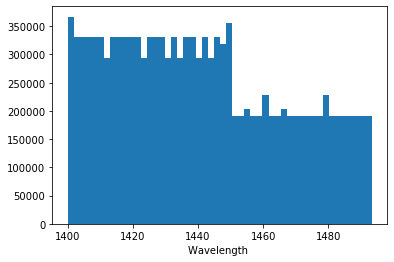

In [19]:
# make a histogram with the wavelength data to look at the data distribution
_ = plt.hist(fnpdf[fnpdf['w0']>=1400]['w0'],bins=50)
plt.xlabel('Wavelength ')

### Plot flux and polarization data at certain specific observation sequence as a function of wavelength.  

In [20]:
# look at the data set at a specific observation sequence. 
fnpdf[(fnpdf['orbitnum']==528)&(fnpdf['orbittype']==7)&(fnpdf['ObsvSeq']==216)]

,r0,w0,r1,w1,pol,orbitnum,orbittype,ObsvSeq,localtime,lat,lon,phase,sza,emission,azimuth,beta
997050,14.906052,1493.369141,14.669285,1493.334961,-0.008006,528,7,216,7.016111,-39.8963,358.367,79.05,79.04,0.05,101.532217,78.4583
997051,15.682190,1493.133423,14.696179,1493.099243,-0.032458,528,7,216,7.016111,-39.8963,358.367,79.05,79.04,0.05,101.532217,78.4583
997052,14.578525,1492.897949,14.334883,1492.863525,-0.008427,528,7,216,7.016111,-39.8963,358.367,79.05,79.04,0.05,101.532217,78.4583
997053,14.604967,1492.662354,15.140710,1492.627930,0.018011,528,7,216,7.016111,-39.8963,358.367,79.05,79.04,0.05,101.532217,78.4583
997054,15.763252,1492.427002,14.782823,1492.392334,-0.032097,528,7,216,7.016111,-39.8963,358.367,79.05,79.04,0.05,101.532217,78.4583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997470,19.466278,1400.834229,20.663887,1400.774048,0.029843,528,7,216,7.016111,-39.8963,358.367,79.05,79.04,0.05,101.532217,78.4583
997471,20.188955,1400.628296,19.874935,1400.568115,-0.007838,528,7,216,7.016111,-39.8963,358.367,79.05,79.04,0.05,101.532217,78.4583
997472,19.452709,1400.422485,20.658743,1400.362183,0.030067,528,7,216,7.016111,-39.8963,358.367,79.05,79.04,0.05,101.532217,78.4583
997473,19.452971,1400.216675,20.656216,1400.156372,0.029999,528,7,216,7.016111,-39.8963,358.367,79.05,79.04,0.05,101.532217,78.4583


Text(0.5, 1.0, 'DOLP')

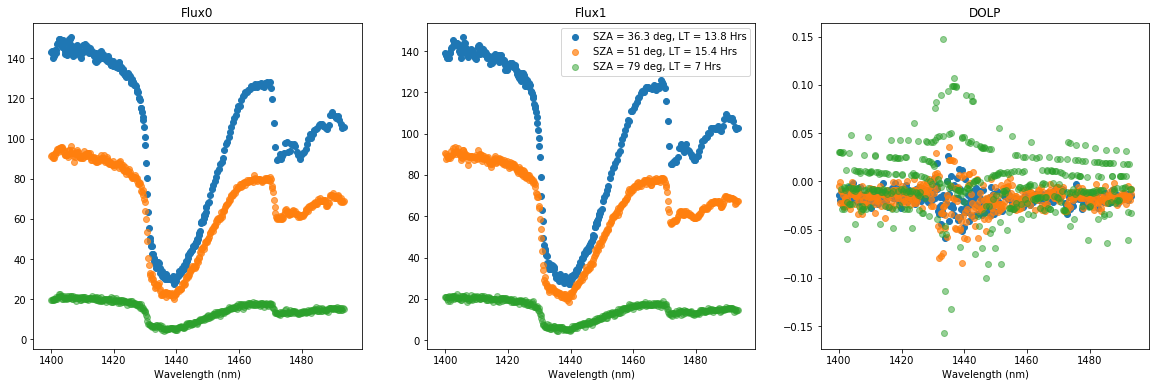

In [21]:
#fnpdf = fluxnpoldf.copy()
#del(fluxnpoldf)
#df = fnpdf[(fnpdf['w0']>=1400)&(fnpdf['w0']<=1400.2)]
#fields=list([['localtime',6,18],['lat',-60,60]])
#print(fields[1])
#df = filter_data(fnpdf,fields=fields)
%matplotlib inline
df = fnpdf[(fnpdf['orbitnum']==1489)&(fnpdf['orbittype']==7)&(fnpdf['ObsvSeq']==0)]
plt.figure(figsize=[20,6])
ax1 = plt.subplot(131)
plt.scatter(df['w0'],df['r0'])
ax2 = plt.subplot(132)
plt.scatter(df['w1'],df['r1'],label='SZA = 36.3 deg, LT = 13.8 Hrs')
ax3 = plt.subplot(133)
plt.scatter(df['w0'],df['pol'])
df = fnpdf[(fnpdf['orbitnum']==494)&(fnpdf['orbittype']==14)&(fnpdf['ObsvSeq']==23)]
ax1.scatter(df['w0'],df['r0'],alpha=0.7)
ax2.scatter(df['w1'],df['r1'],label='SZA = 51 deg, LT = 15.4 Hrs',alpha=0.7)
ax3.scatter(df['w0'],df['pol'],alpha=0.7)

df = fnpdf[(fnpdf['orbitnum']==528)&(fnpdf['orbittype']==7)&(fnpdf['ObsvSeq']==216)]
ax1.scatter(df['w0'],df['r0'],alpha=0.5)
ax2.scatter(df['w1'],df['r1'],label='SZA = 79 deg, LT = 7 Hrs',alpha=0.5)
ax3.scatter(df['w0'],df['pol'],alpha=0.5)
ax2.legend()
ax1.set_xlabel('Wavelength (nm)')
ax2.set_xlabel('Wavelength (nm)')
ax3.set_xlabel('Wavelength (nm)')
ax1.set_title('Flux0',fontsize='large')
ax2.set_title('Flux1',fontsize='large')
ax3.set_title('DOLP',fontsize='large')

In [22]:
fnpdf[(fnpdf['orbitnum']==494)&(fnpdf['orbittype']==14)&(fnpdf['ObsvSeq']==23)]

,r0,w0,r1,w1,pol,orbitnum,orbittype,ObsvSeq,localtime,lat,lon,phase,sza,emission,azimuth,beta
9775,68.993584,1493.369141,67.161552,1493.334961,-0.013455,494,14,23,15.412778,-10.8526,127.9943,52.72,52.68,0.11,111.284645,68.637294
9776,68.355537,1493.133423,67.286469,1493.099243,-0.007882,494,14,23,15.412778,-10.8526,127.9943,52.72,52.68,0.11,111.284645,68.637294
9777,68.838234,1492.897949,66.237061,1492.863525,-0.019257,494,14,23,15.412778,-10.8526,127.9943,52.72,52.68,0.11,111.284645,68.637294
9778,68.204056,1492.662354,65.988190,1492.627930,-0.016513,494,14,23,15.412778,-10.8526,127.9943,52.72,52.68,0.11,111.284645,68.637294
9779,70.227852,1492.427002,68.079140,1492.392334,-0.015536,494,14,23,15.412778,-10.8526,127.9943,52.72,52.68,0.11,111.284645,68.637294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,92.354317,1400.834229,88.339645,1400.774048,-0.022218,494,14,23,15.412778,-10.8526,127.9943,52.72,52.68,0.11,111.284645,68.637294
10196,90.882965,1400.628296,89.146629,1400.568115,-0.009645,494,14,23,15.412778,-10.8526,127.9943,52.72,52.68,0.11,111.284645,68.637294
10197,90.100777,1400.422485,89.903015,1400.362183,-0.001099,494,14,23,15.412778,-10.8526,127.9943,52.72,52.68,0.11,111.284645,68.637294
10198,91.553978,1400.216675,87.504898,1400.156372,-0.022613,494,14,23,15.412778,-10.8526,127.9943,52.72,52.68,0.11,111.284645,68.637294


### Now plot the data pertaining to specific wavelength intervals chosen for data fitting

### Data at SZA = 30 deg for three different points of wavelength with increasing absorption strength

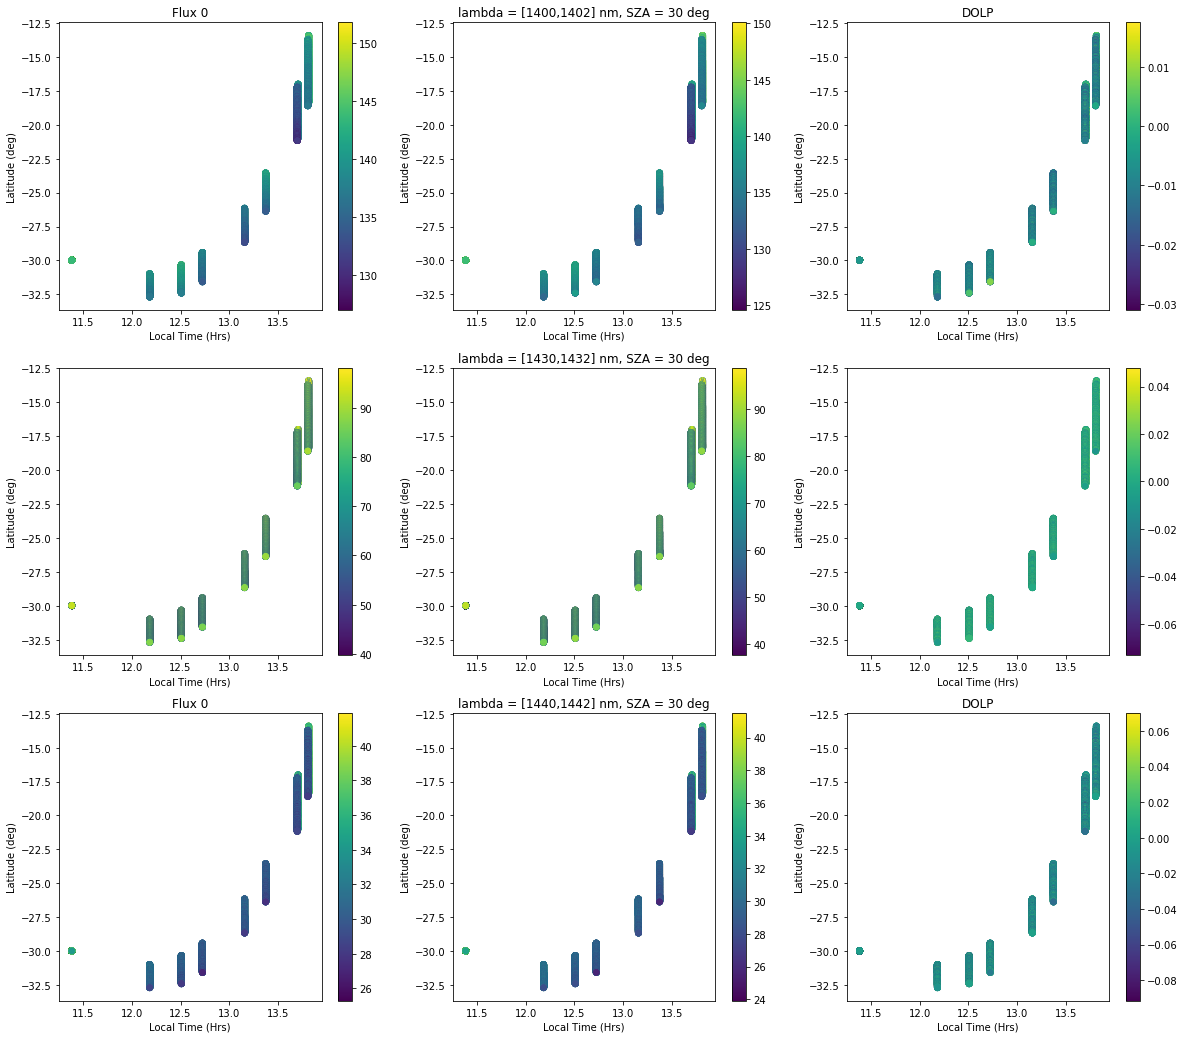

In [23]:
# filter all data between wavelength [1400,1402] and SZA [29,31]
fields=list([['w0',1400,1402],['sza',29,31]])
df = filter_data(fnpdf,fields=fields)
#print(fields[1])
plt.figure(figsize=[20,18])
plt.subplot(331)
plt.title('Flux 0',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['r0'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(332)
plt.title('lambda = [1400,1402] nm, SZA = 30 deg')
plt.scatter(df['localtime'],df['lat'],c=df['r1'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(333)
plt.title('DOLP',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['pol'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()

# filter all data between wavelength [1430,1432]
fields=list([['w0',1430,1432],['sza',29,31]])
df = filter_data(fnpdf,fields=fields)
plt.subplot(334)
plt.scatter(df['localtime'],df['lat'],c=df['r0'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(335)
plt.title('lambda = [1430,1432] nm, SZA = 30 deg')
plt.scatter(df['localtime'],df['lat'],c=df['r1'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(336)
plt.scatter(df['localtime'],df['lat'],c=df['pol'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()

# filter all data between wavelength [1440,1442]
fields=list([['w0',1440,1442],['sza',29,31]])
df = filter_data(fnpdf,fields=fields)
plt.subplot(337)
plt.title('Flux 0',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['r0'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(338)
plt.title('lambda = [1440,1442] nm, SZA = 30 deg')
plt.scatter(df['localtime'],df['lat'],c=df['r1'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(339)
plt.title('DOLP',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['pol'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
#plt.savefig('../outputs/datascatter_sza30.pdf')

### Filter the same as above but now at SZA = 60 deg 

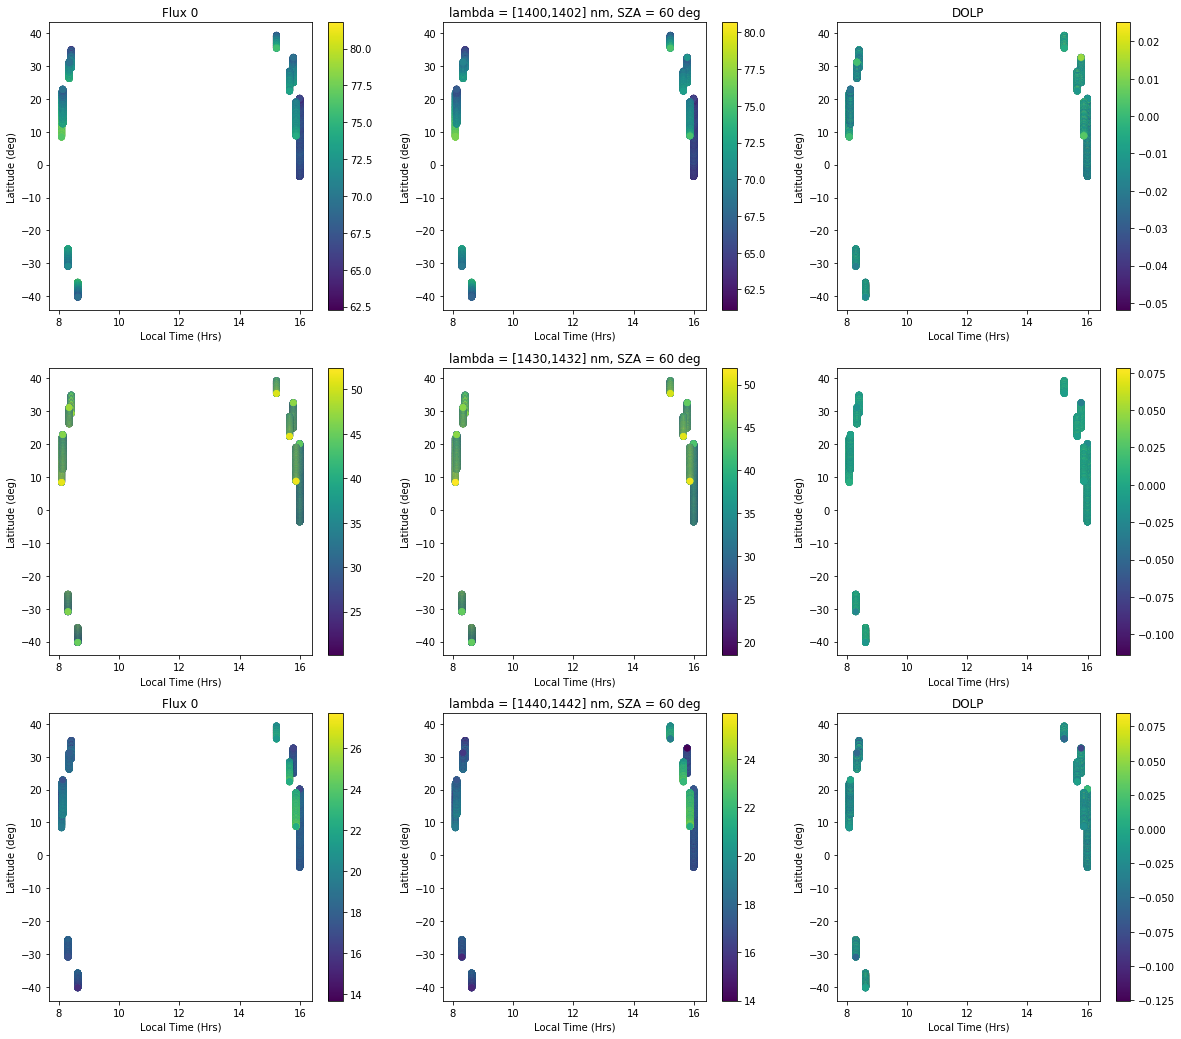

In [24]:
# filter all data between wavelength [1400,1402] and SZA [29,31]
fields=list([['w0',1400,1402],['sza',59,61]])
df = filter_data(fnpdf,fields=fields)
#print(fields[1])
plt.figure(figsize=[20,18])
plt.subplot(331)
plt.title('Flux 0',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['r0'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(332)
plt.title('lambda = [1400,1402] nm, SZA = 60 deg')
plt.scatter(df['localtime'],df['lat'],c=df['r1'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(333)
plt.title('DOLP',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['pol'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()

# filter all data between wavelength [1430,1432]
fields=list([['w0',1430,1432],['sza',59,61]])
df = filter_data(fnpdf,fields=fields)
plt.subplot(334)
plt.scatter(df['localtime'],df['lat'],c=df['r0'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(335)
plt.title('lambda = [1430,1432] nm, SZA = 60 deg')
plt.scatter(df['localtime'],df['lat'],c=df['r1'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(336)
plt.scatter(df['localtime'],df['lat'],c=df['pol'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()

# filter all data between wavelength [1440,1442]
fields=list([['w0',1440,1442],['sza',59,61]])
df = filter_data(fnpdf,fields=fields)
plt.subplot(337)
plt.title('Flux 0',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['r0'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(338)
plt.title('lambda = [1440,1442] nm, SZA = 60 deg')
plt.scatter(df['localtime'],df['lat'],c=df['r1'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(339)
plt.title('DOLP',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['pol'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
#plt.savefig('../outputs/datascatter_sza60.pdf')

### Filter the same as above but now at SZA = 80 deg 

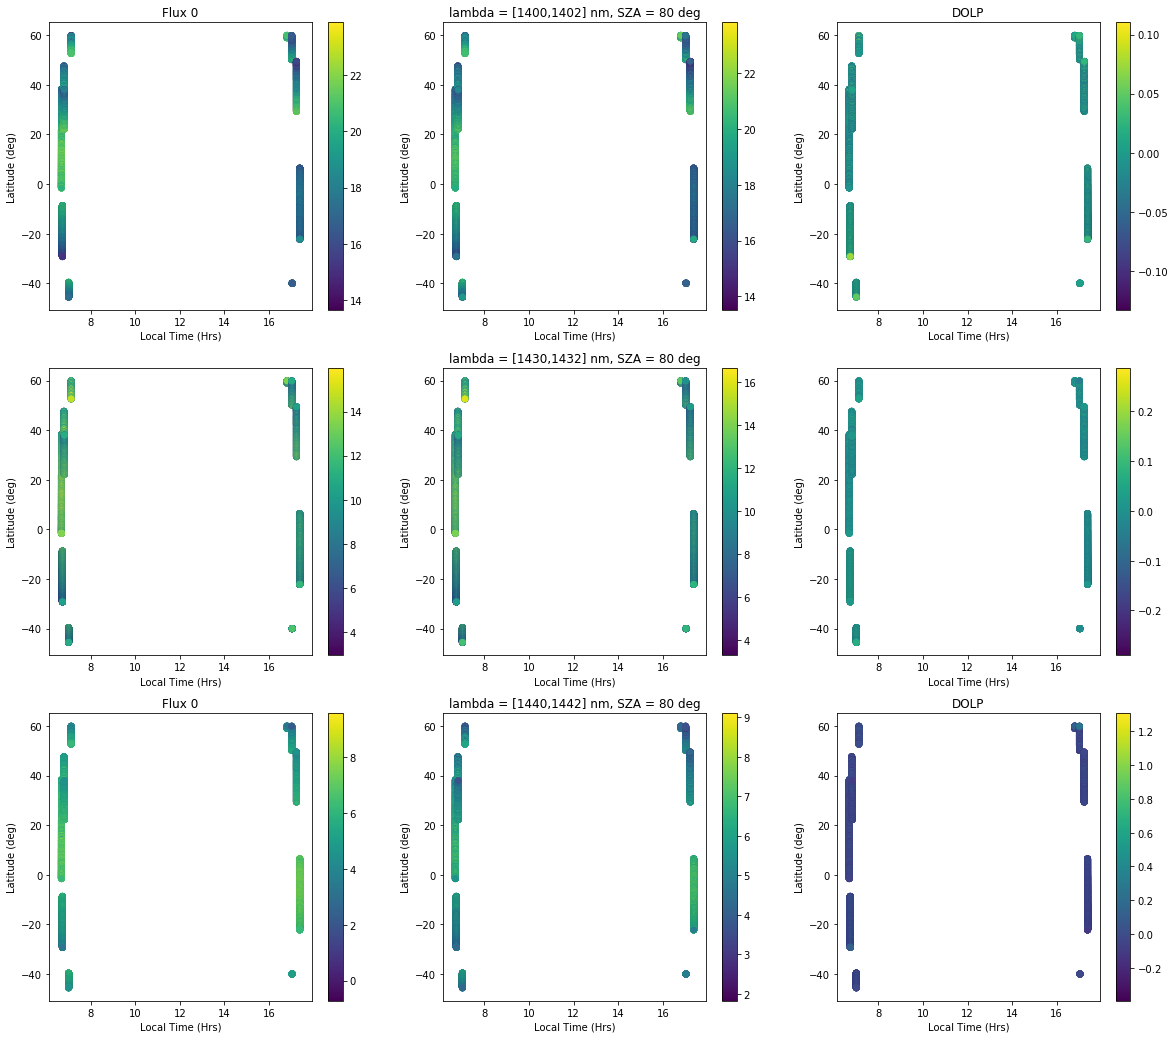

In [25]:
# filter all data between wavelength [1400,1402] and SZA [29,31]
fields=list([['w0',1400,1402],['sza',79,81]])
df = filter_data(fnpdf,fields=fields)
#print(fields[1])
plt.figure(figsize=[20,18])
plt.subplot(331)
plt.title('Flux 0',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['r0'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(332)
plt.title('lambda = [1400,1402] nm, SZA = 80 deg')
plt.scatter(df['localtime'],df['lat'],c=df['r1'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(333)
plt.title('DOLP',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['pol'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()

# filter all data between wavelength [1430,1432]
fields=list([['w0',1430,1432],['sza',79,81]])
df = filter_data(fnpdf,fields=fields)
plt.subplot(334)
plt.scatter(df['localtime'],df['lat'],c=df['r0'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(335)
plt.title('lambda = [1430,1432] nm, SZA = 80 deg')
plt.scatter(df['localtime'],df['lat'],c=df['r1'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(336)
plt.scatter(df['localtime'],df['lat'],c=df['pol'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()

# filter all data between wavelength [1440,1442]
fields=list([['w0',1440,1442],['sza',79,81]])
df = filter_data(fnpdf,fields=fields)
plt.subplot(337)
plt.title('Flux 0',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['r0'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(338)
plt.title('lambda = [1440,1442] nm, SZA = 80 deg')
plt.scatter(df['localtime'],df['lat'],c=df['r1'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
plt.subplot(339)
plt.title('DOLP',fontsize='large')
plt.scatter(df['localtime'],df['lat'],c=df['pol'])
plt.xlabel('Local Time (Hrs)')
plt.ylabel('Latitude (deg)')
clb = plt.colorbar()
#plt.savefig('../outputs/datascatter_sza80.pdf')

### Make an initial attempt at retrievals 

In [26]:
# load the retrieval model data
modeldf = pd.read_csv('../outputs/RetrievalModelData.csv')
modeldf

,Unnamed: 0,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),CO,HSH(km),HO,alpha,theta0,theta,phi,beta
0,0,1.0,0.0,1400,0.840786,0.000000,0.0,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,1419,0.726821,0.000000,0.0,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
2,2,1.0,0.0,1430,0.139299,0.000000,0.0,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
3,3,1.0,0.0,1440,0.016076,0.000000,0.0,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
4,4,1.0,0.0,1450,0.175177,0.000000,0.0,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5217025,5217025,105.0,8280.0,1419,9950.234792,354.076659,0.0,-0.035585,6.0,79.0,30.0,4.0,0.1,0.0,180.0,0.0,180.0,0.0
5217026,5217026,105.0,8280.0,1430,6720.807975,358.374772,0.0,-0.053323,6.0,79.0,30.0,4.0,0.1,0.0,180.0,0.0,180.0,0.0
5217027,5217027,105.0,8280.0,1440,19990.663155,-4307.004713,0.0,0.215451,6.0,79.0,30.0,4.0,0.1,0.0,180.0,0.0,180.0,0.0
5217028,5217028,105.0,8280.0,1450,24433.860344,-3052.070527,0.0,0.124912,6.0,79.0,30.0,4.0,0.1,0.0,180.0,0.0,180.0,0.0


### Perform convolution of each data point with the solar incoming flux 

In [27]:
# first look at all the model data at 1400 nm
modeldf[modeldf['Lambda'] == 1400]

,Unnamed: 0,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),CO,HSH(km),HO,alpha,theta0,theta,phi,beta
0,0,1.0,0.0,1400,0.840786,0.000000,0.000000,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,0.0,0.0
6,6,1.0,1.0,1400,0.840786,0.000000,0.000000,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,2.0,0.0
12,12,1.0,2.0,1400,0.840786,0.000000,0.000000,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,4.0,0.0
18,18,1.0,3.0,1400,0.840786,0.000000,0.000000,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,6.0,0.0
24,24,1.0,4.0,1400,0.840786,0.000000,0.000000,-0.000000,2.0,60.0,30.0,4.0,0.1,0.0,0.0,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5217000,5217000,105.0,8276.0,1400,9966.008208,408.999915,-117.278838,-0.041039,6.0,79.0,30.0,4.0,0.1,0.0,180.0,0.0,172.0,0.0
5217006,5217006,105.0,8277.0,1400,9966.008208,416.184570,-88.462761,-0.041760,6.0,79.0,30.0,4.0,0.1,0.0,180.0,0.0,174.0,0.0
5217012,5217012,105.0,8278.0,1400,9966.008208,421.341617,-59.215702,-0.042278,6.0,79.0,30.0,4.0,0.1,0.0,180.0,0.0,176.0,0.0
5217018,5217018,105.0,8279.0,1400,9966.008208,424.445927,-29.680150,-0.042589,6.0,79.0,30.0,4.0,0.1,0.0,180.0,0.0,178.0,0.0


In [28]:
# load the solar spectrum
def convolve_solarflux(wavin):
    '''
    This function returns the solar spectra at the exact points as supplied by a wavelength. 
    Wavelength should be in microns!
    '''
    # get the path to the file
    solarflux = np.loadtxt('/Users/gouravmahapatr/Dropbox/PhD/Codes/PythonCodes/solarflux_venus.dat')
    # make an interpolation object as a function of solar flux and wavelength
    wavsun = solarflux[:,0]       # not converted into microns!!!
    flux = solarflux[:,1]
    intp_solar = interpolate.interp1d(wavsun,flux)   
    return intp_solar(wavin)
lamb = np.linspace(1400,1500,100)
solarflux = convolve_solarflux(lamb)

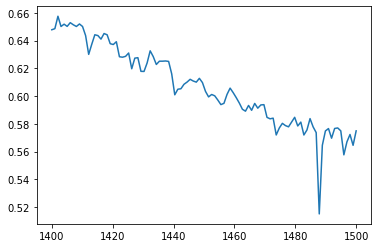

In [29]:
plt.plot(lamb,solarflux)

In [30]:
modeldf[modeldf['Lambda']==1419]['F']

1             0.726821
7             0.726821
13            0.726821
19            0.726821
25            0.726821
              ...     
5217001    9950.234792
5217007    9950.234792
5217013    9950.234792
5217019    9950.234792
5217025    9950.234792
Name: F, Length: 869505, dtype: float64

In [31]:
modeldf['Lambda'].unique()

array([1400, 1419, 1430, 1440, 1450, 1470])

In [32]:
modeldf['Fconv'] = convolve_solarflux(modeldf['Lambda'])*modeldf['F']
modeldf['Qconv'] = convolve_solarflux(modeldf['Lambda'])*modeldf['Q']
modeldf['Uconv'] = convolve_solarflux(modeldf['Lambda'])*modeldf['U']
modeldf['Pconv'] = -modeldf['Qconv']/modeldf['Fconv']

In [33]:
modeldf[modeldf['Pconv']>90]

,Unnamed: 0,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),...,HO,alpha,theta0,theta,phi,beta,Fconv,Qconv,Uconv,Pconv
4204460,4204460,85.0,5139.0,1430,0.666674,-60.480224,8.499941,90.719308,5.0,80.0,...,0.1,0.0,112.0,0.0,86.0,0.0,0.411271,-37.310250,5.243614,90.719308
4204466,4204466,85.0,5140.0,1430,0.666674,-60.925823,4.260349,91.387699,5.0,80.0,...,0.1,0.0,112.0,0.0,88.0,0.0,0.411271,-37.585140,2.628209,91.387699
4204472,4204472,85.0,5141.0,1430,0.666674,-61.074598,0.000000,91.610858,5.0,80.0,...,0.1,0.0,112.0,0.0,90.0,0.0,0.411271,-37.676919,0.000000,91.610858
4204478,4204478,85.0,5142.0,1430,0.666674,-60.925823,-4.260349,91.387699,5.0,80.0,...,0.1,0.0,112.0,0.0,92.0,0.0,0.411271,-37.585140,-2.628209,91.387699
4204484,4204484,85.0,5143.0,1430,0.666674,-60.480224,-8.499941,90.719308,5.0,80.0,...,0.1,0.0,112.0,0.0,94.0,0.0,0.411271,-37.310250,-5.243614,90.719308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4223054,4223054,85.0,8238.0,1430,11.179345,-1134.419731,-241.128358,101.474616,5.0,80.0,...,0.1,0.0,180.0,0.0,96.0,0.0,6.896538,-699.823532,-148.752084,101.474616
4223060,4223060,85.0,8239.0,1430,11.179345,-1114.836078,-319.674098,99.722845,5.0,80.0,...,0.1,0.0,180.0,0.0,98.0,0.0,6.896538,-687.742376,-197.206951,99.722845
4223066,4223066,85.0,8240.0,1430,11.179345,-1089.821059,-396.662427,97.485235,5.0,80.0,...,0.1,0.0,180.0,0.0,100.0,0.0,6.896538,-672.310611,-244.701051,97.485235
4223072,4223072,85.0,8241.0,1430,11.179345,-1059.496529,-471.718245,94.772685,5.0,80.0,...,0.1,0.0,180.0,0.0,102.0,0.0,6.896538,-653.603409,-291.002985,94.772685


In [34]:
fnpdf[(fnpdf['lat']<5)&(fnpdf['lat']>-5)]

,r0,w0,r1,w1,pol,orbitnum,orbittype,ObsvSeq,localtime,lat,lon,phase,sza,emission,azimuth,beta
49725,70.817970,1493.369141,69.439133,1493.334961,-0.009831,494,14,117,15.413056,-4.9364,128.0044,51.74,51.71,0.13,103.292450,76.607743
49726,70.183861,1493.133423,68.791100,1493.099243,-0.010022,494,14,117,15.413056,-4.9364,128.0044,51.74,51.71,0.13,103.292450,76.607743
49727,71.047501,1492.897949,68.912865,1492.863525,-0.015252,494,14,117,15.413056,-4.9364,128.0044,51.74,51.71,0.13,103.292450,76.607743
49728,70.797180,1492.662354,69.840141,1492.627930,-0.006805,494,14,117,15.413056,-4.9364,128.0044,51.74,51.71,0.13,103.292450,76.607743
49729,70.925591,1492.427002,69.592270,1492.392334,-0.009489,494,14,117,15.413056,-4.9364,128.0044,51.74,51.71,0.13,103.292450,76.607743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11109705,23.877441,1400.834229,23.893860,1400.774048,0.000344,1311,4,176,6.826389,4.9667,257.4081,77.75,77.75,0.05,89.994572,89.994572
11109706,23.873985,1400.628296,21.514725,1400.568115,-0.051979,1311,4,176,6.826389,4.9667,257.4081,77.75,77.75,0.05,89.994572,89.994572
11109707,24.586712,1400.422485,21.505886,1400.362183,-0.066840,1311,4,176,6.826389,4.9667,257.4081,77.75,77.75,0.05,89.994572,89.994572
11109708,24.586691,1400.216675,23.090685,1400.156372,-0.031378,1311,4,176,6.826389,4.9667,257.4081,77.75,77.75,0.05,89.994572,89.994572


In [35]:
df = fnpdf[(fnpdf['orbitnum']==494)&(fnpdf['orbittype']==14)&(fnpdf['ObsvSeq']==117)]

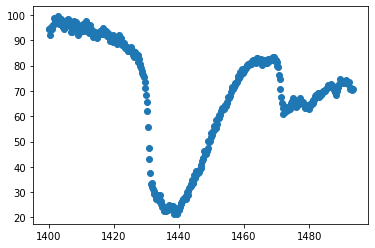

In [36]:
%matplotlib inline
plt.scatter(df['w0'],df['r0'])

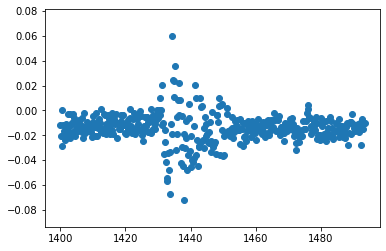

In [37]:
plt.scatter(df['w0'],df['pol'])

In [38]:
r0 = df[(df['w0']>=1400)&(df['w0']<=1401)].mean()['r0']

In [39]:
modeldf['Lambda'].unique()

array([1400, 1419, 1430, 1440, 1450, 1470])

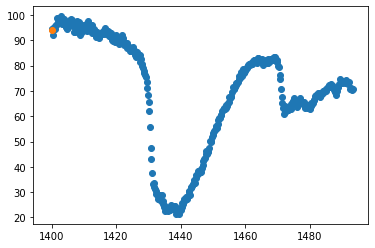

In [40]:
plt.scatter(df['w0'],df['r0'])
plt.scatter(1400,r0)

In [41]:
r0 = df['r0']/(df[(df['w0']>=1400)&(df['w0']<=1401)].mean()['r0'])
r1 = df['r1']/(df[(df['w0']>=1400)&(df['w0']<=1401)].mean()['r1'])

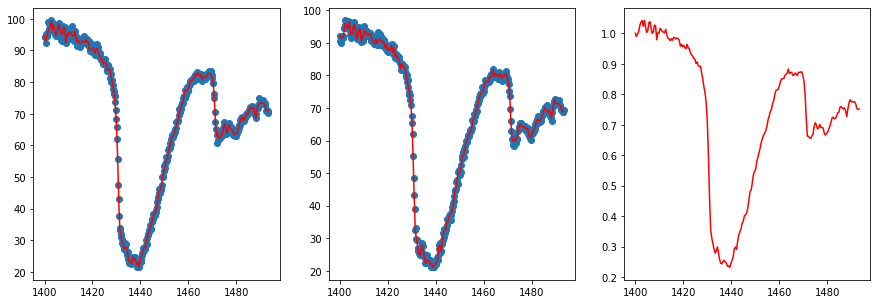

In [100]:
lamb = np.linspace(df['w0'].min(),df['w0'].max(),200)
# This performs an interpolation between the data points
intp0 = interpolate.interp1d(df['w0'],df['r0'],kind='linear')
r0int = intp0(lamb)
lamb = np.linspace(df['w1'].min(),df['w1'].max(),200)
intp1 = interpolate.interp1d(df['w1'],df['r1'],kind='linear')
r1int = intp1(lamb)
# add the fluxes and normalize
ravg = ravg/ravg[0]

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(df['w0'],df['r0'])
plt.plot(np.linspace(df['w0'].min(),df['w0'].max(),200),r0int,c='r')
plt.subplot(132)
plt.scatter(df['w1'],df['r1'])
plt.plot(np.linspace(df['w1'].min(),df['w1'].max(),200),r1int,c='r')
plt.subplot(133)
#plt.scatter(df['w0'],df['pol'])
plt.plot(np.linspace(df['w1'].min(),df['w1'].max(),200),ravg,c='r')

In [108]:
def get_normflux(df,lamb):
    '''
    This function takes the data and returns datapoints as a function of the wavelength list. 
    '''
    #lamb = np.linspace(df['w0'].min(),df['w0'].max(),200)
    # This performs an interpolation between the data points
    intp0 = interpolate.interp1d(df['w0'],df['r0'],kind='linear')
    r0int = intp0(lamb+0.05)
    #lamb = np.linspace(df['w1'].min(),df['w1'].max(),200)
    intp1 = interpolate.interp1d(df['w1'],df['r1'],kind='linear')
    r1int = intp1(lamb+0.05)
    # add the fluxes and normalize
    ravg = r0int+r1int
    ravg = ravg/ravg[0]
    return ravg

In [43]:
modeldf

,Unnamed: 0,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),...,HO,alpha,theta0,theta,phi,beta,Fconv,Qconv,Uconv,Pconv
0,0,1.0,0.0,1400,0.840786,0.000000,0.0,-0.000000,2.0,60.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.544661,0.000000,0.0,-0.000000
1,1,1.0,0.0,1419,0.726821,0.000000,0.0,-0.000000,2.0,60.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.463857,0.000000,0.0,-0.000000
2,2,1.0,0.0,1430,0.139299,0.000000,0.0,-0.000000,2.0,60.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.085934,0.000000,0.0,-0.000000
3,3,1.0,0.0,1440,0.016076,0.000000,0.0,-0.000000,2.0,60.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.009607,0.000000,0.0,-0.000000
4,4,1.0,0.0,1450,0.175177,0.000000,0.0,-0.000000,2.0,60.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.106385,0.000000,0.0,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5217025,5217025,105.0,8280.0,1419,9950.234792,354.076659,0.0,-0.035585,6.0,79.0,...,0.1,0.0,180.0,0.0,180.0,0.0,6350.239844,225.971724,0.0,-0.035585
5217026,5217026,105.0,8280.0,1430,6720.807975,358.374772,0.0,-0.053323,6.0,79.0,...,0.1,0.0,180.0,0.0,180.0,0.0,4146.066440,221.081397,0.0,-0.053323
5217027,5217027,105.0,8280.0,1440,19990.663155,-4307.004713,0.0,0.215451,6.0,79.0,...,0.1,0.0,180.0,0.0,180.0,0.0,11946.420302,-2573.866016,0.0,0.215451
5217028,5217028,105.0,8280.0,1450,24433.860344,-3052.070527,0.0,0.124912,6.0,79.0,...,0.1,0.0,180.0,0.0,180.0,0.0,14838.683387,-1853.522431,0.0,0.124912


In [44]:
filtmodeldf = filter_data(modeldf,fields=[['theta0',51,52],['phi',103,104]])

In [45]:
filtmodeldf

,Unnamed: 0,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),...,HO,alpha,theta0,theta,phi,beta,Fconv,Qconv,Uconv,Pconv
14508,14508,1.0,2418.0,1400,0.761223,-0.004169,-0.002217,0.005476,2.0,60.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.493120,-0.002700,-0.001436,0.005476
14509,14509,1.0,2418.0,1419,0.668472,-0.003731,-0.001984,0.005581,2.0,60.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.426619,-0.002381,-0.001266,0.005581
14510,14510,1.0,2418.0,1430,0.133545,-0.000471,-0.000250,0.003524,2.0,60.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.082384,-0.000290,-0.000154,0.003524
14511,14511,1.0,2418.0,1440,0.015153,0.001008,0.000536,-0.066523,2.0,60.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.009055,0.000602,0.000320,-0.066523
14512,14512,1.0,2418.0,1450,0.172674,-0.000799,-0.000425,0.004629,2.0,60.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.104865,-0.000485,-0.000258,0.004629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5181853,5181853,105.0,2418.0,1419,0.766829,-0.004014,-0.002134,0.005235,6.0,79.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.489390,-0.002562,-0.001362,0.005235
5181854,5181854,105.0,2418.0,1430,0.468695,-0.002905,-0.001545,0.006199,6.0,79.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.289138,-0.001792,-0.000953,0.006199
5181855,5181855,105.0,2418.0,1440,0.350230,-0.002631,-0.001399,0.007513,6.0,79.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.209297,-0.001573,-0.000836,0.007513
5181856,5181856,105.0,2418.0,1450,0.616329,-0.003261,-0.001734,0.005290,6.0,79.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.374297,-0.001980,-0.001053,0.005290


In [48]:
filtmodeldf = filter_data(modeldf,[['theta0',round(df['sza'].iloc[0]),round(df['sza'].iloc[0]+1)],['phi',round(df['azimuth'].iloc[0]),round(df['azimuth'].iloc[0]+1)]])
filtmodeldf

,Unnamed: 0,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),...,HO,alpha,theta0,theta,phi,beta,Fconv,Qconv,Uconv,Pconv
14508,14508,1.0,2418.0,1400,0.761223,-0.004169,-0.002217,0.005476,2.0,60.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.493120,-0.002700,-0.001436,0.005476
14509,14509,1.0,2418.0,1419,0.668472,-0.003731,-0.001984,0.005581,2.0,60.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.426619,-0.002381,-0.001266,0.005581
14510,14510,1.0,2418.0,1430,0.133545,-0.000471,-0.000250,0.003524,2.0,60.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.082384,-0.000290,-0.000154,0.003524
14511,14511,1.0,2418.0,1440,0.015153,0.001008,0.000536,-0.066523,2.0,60.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.009055,0.000602,0.000320,-0.066523
14512,14512,1.0,2418.0,1450,0.172674,-0.000799,-0.000425,0.004629,2.0,60.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.104865,-0.000485,-0.000258,0.004629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5181853,5181853,105.0,2418.0,1419,0.766829,-0.004014,-0.002134,0.005235,6.0,79.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.489390,-0.002562,-0.001362,0.005235
5181854,5181854,105.0,2418.0,1430,0.468695,-0.002905,-0.001545,0.006199,6.0,79.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.289138,-0.001792,-0.000953,0.006199
5181855,5181855,105.0,2418.0,1440,0.350230,-0.002631,-0.001399,0.007513,6.0,79.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.209297,-0.001573,-0.000836,0.007513
5181856,5181856,105.0,2418.0,1450,0.616329,-0.003261,-0.001734,0.005290,6.0,79.0,...,0.1,0.0,52.0,0.0,104.0,0.0,0.374297,-0.001980,-0.001053,0.005290


In [49]:
def get_normdf(filtmodeldf):
    '''This function takes a model dataframe and adds the normalized fluxes as new columns.'''
    models = filtmodeldf['ModelNum'].unique()
    geoms = filtmodeldf['GeomNum'].unique()

    tempdf = filtmodeldf[(filtmodeldf['ModelNum']==models[0])&(filtmodeldf['GeomNum']==geoms[0])]
    tempdf['Fnorm'] = tempdf['Fconv']/tempdf[tempdf['Lambda']==1400]['Fconv'].iloc[0]
    tempdf['Qnorm'] = tempdf['Qconv']/tempdf[tempdf['Lambda']==1400]['Qconv'].iloc[0]
    tempdf['Unorm'] = tempdf['Uconv']/tempdf[tempdf['Lambda']==1400]['Uconv'].iloc[0]
    normdf = tempdf.copy()

    if (len(models)>1)|(len(geoms)>1):
        for i in range(len(models)):
            for j in range(len(geoms)):
                if (models[i]!=models[0])|(geoms[j]!=geoms[0]):
                    tempdf = filtmodeldf[(filtmodeldf['ModelNum']==models[i])&(filtmodeldf['GeomNum']==geoms[j])]
                    tempdf['Fnorm'] = tempdf['Fconv']/tempdf[tempdf['Lambda']==1400]['Fconv'].iloc[0]
                    tempdf['Qnorm'] = tempdf['Qconv']/tempdf[tempdf['Lambda']==1400]['Qconv'].iloc[0]
                    tempdf['Unorm'] = tempdf['Uconv']/tempdf[tempdf['Lambda']==1400]['Uconv'].iloc[0]
                    normdf = pd.concat([normdf,tempdf],ignore_index=True)
    normdf = normdf.drop(columns=['Unnamed: 0'])
    return normdf

In [50]:
normdf = get_normdf(filtmodeldf)
normdf

/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),CO,...,theta,phi,beta,Fconv,Qconv,Uconv,Pconv,Fnorm,Qnorm,Unorm
0,1.0,2418.0,1400,0.761223,-0.004169,-0.002217,0.005476,2.0,60.0,30.0,...,0.0,104.0,0.0,0.493120,-0.002700,-0.001436,0.005476,1.000000,1.000000,1.000000
1,1.0,2418.0,1419,0.668472,-0.003731,-0.001984,0.005581,2.0,60.0,30.0,...,0.0,104.0,0.0,0.426619,-0.002381,-0.001266,0.005581,0.865143,0.881647,0.881647
2,1.0,2418.0,1430,0.133545,-0.000471,-0.000250,0.003524,2.0,60.0,30.0,...,0.0,104.0,0.0,0.082384,-0.000290,-0.000154,0.003524,0.167066,0.107509,0.107509
3,1.0,2418.0,1440,0.015153,0.001008,0.000536,-0.066523,2.0,60.0,30.0,...,0.0,104.0,0.0,0.009055,0.000602,0.000320,-0.066523,0.018363,-0.223064,-0.223064
4,1.0,2418.0,1450,0.172674,-0.000799,-0.000425,0.004629,2.0,60.0,30.0,...,0.0,104.0,0.0,0.104865,-0.000485,-0.000258,0.004629,0.212656,0.179751,0.179751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,105.0,2418.0,1419,0.766829,-0.004014,-0.002134,0.005235,6.0,79.0,30.0,...,0.0,104.0,0.0,0.489390,-0.002562,-0.001362,0.005235,0.977782,0.906798,0.906798
626,105.0,2418.0,1430,0.468695,-0.002905,-0.001545,0.006199,6.0,79.0,30.0,...,0.0,104.0,0.0,0.289138,-0.001792,-0.000953,0.006199,0.577686,0.634435,0.634435
627,105.0,2418.0,1440,0.350230,-0.002631,-0.001399,0.007513,6.0,79.0,30.0,...,0.0,104.0,0.0,0.209297,-0.001573,-0.000836,0.007513,0.418168,0.556625,0.556625
628,105.0,2418.0,1450,0.616329,-0.003261,-0.001734,0.005290,6.0,79.0,30.0,...,0.0,104.0,0.0,0.374297,-0.001980,-0.001053,0.005290,0.747830,0.700913,0.700913


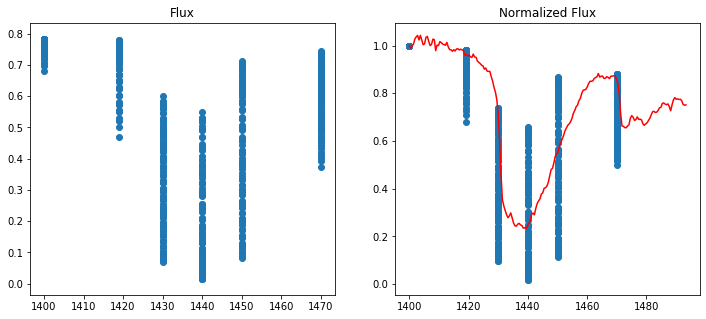

In [51]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.scatter(filtmodeldf['Lambda'],filtmodeldf['F'])
plt.title('Flux')
plt.subplot(122)
plt.scatter(normdf['Lambda'],normdf['Fnorm'])
plt.title('Normalized Flux')
plt.plot(np.linspace(df['w1'].min(),df['w1'].max(),200),ravg,c='r')

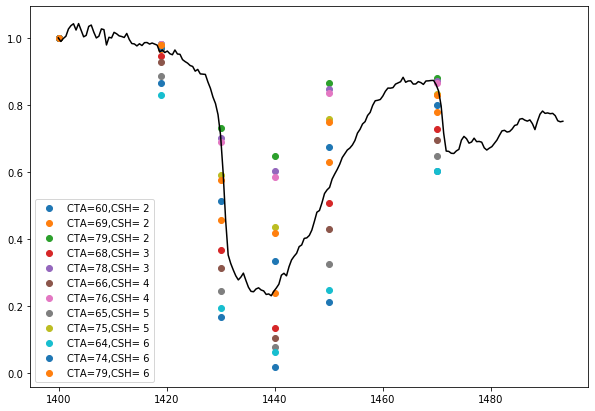

In [52]:
lamb = normdf['Lambda'].unique()
plt.figure(figsize=[10,7])
plt.plot(np.linspace(df['w1'].min(),df['w1'].max(),200),ravg,c='k')
data = normdf[(normdf['ModelNum']==1.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==10.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==20.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==30.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==40.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==50.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==60.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==70.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==80.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==90.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==100.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['ModelNum']==105.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
plt.legend()

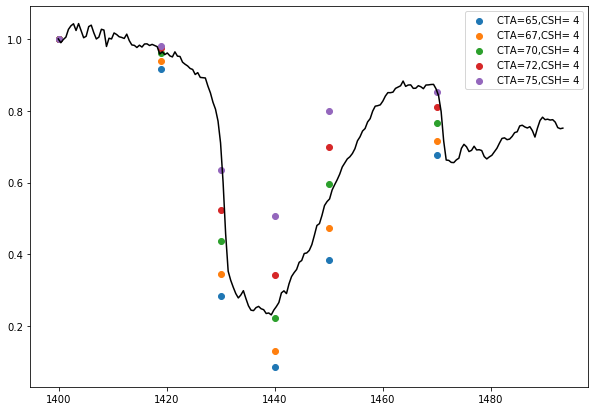

In [60]:
lamb = normdf['Lambda'].unique()
plt.figure(figsize=[10,7])
plt.plot(np.linspace(df['w1'].min(),df['w1'].max(),200),ravg,c='k')
data = normdf[(normdf['CTA(km)']==65.0)&(normdf['CSH(km)']==4.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['CTA(km)']==67.0)&(normdf['CSH(km)']==4.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['CTA(km)']==70.0)&(normdf['CSH(km)']==4.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['CTA(km)']==72.0)&(normdf['CSH(km)']==4.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['CTA(km)']==75.0)&(normdf['CSH(km)']==4.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
plt.legend()

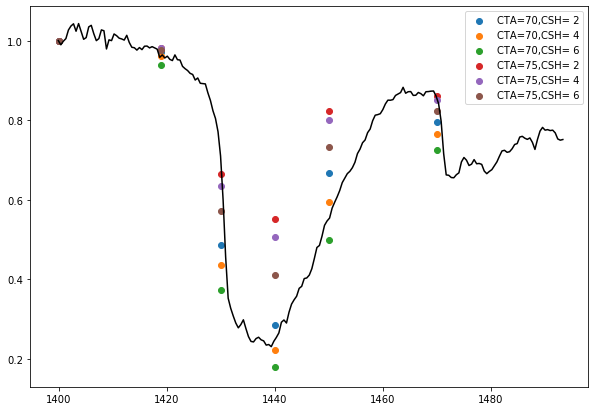

In [61]:
lamb = normdf['Lambda'].unique()
plt.figure(figsize=[10,7])
plt.plot(np.linspace(df['w1'].min(),df['w1'].max(),200),ravg,c='k')
data = normdf[(normdf['CTA(km)']==70.0)&(normdf['CSH(km)']==2.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['CTA(km)']==70.0)&(normdf['CSH(km)']==4.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['CTA(km)']==70.0)&(normdf['CSH(km)']==6.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['CTA(km)']==75.0)&(normdf['CSH(km)']==2.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['CTA(km)']==75.0)&(normdf['CSH(km)']==4.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
data = normdf[(normdf['CTA(km)']==75.0)&(normdf['CSH(km)']==6.0)]
plt.scatter(lamb,data['Fnorm'],label='CTA={:2.0f},CSH={:2.0f}'.format(data['CTA(km)'].iloc[0],data['CSH(km)'].iloc[0]))
plt.legend()

### Get data for a slightly different geometry

In [73]:
normdf2 = modeldf[(modeldf['theta0']==50)&(modeldf['phi']==102.0)]
normdf2 = get_normdf(normdf2)
normdf2

/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,ModelNum,GeomNum,Lambda,F,Q,U,P,CSH(km),CTA(km),CO,...,theta,phi,beta,Fconv,Qconv,Uconv,Pconv,Fnorm,Qnorm,Unorm
0,1.0,2326.0,1400,0.769502,-0.003916,-0.001743,0.005089,2.0,60.0,30.0,...,0.0,102.0,0.0,0.498483,-0.002537,-0.001129,0.005089,1.000000,1.000000,1.000000
1,1.0,2326.0,1419,0.675104,-0.003490,-0.001554,0.005170,2.0,60.0,30.0,...,0.0,102.0,0.0,0.430851,-0.002228,-0.000992,0.005170,0.864324,0.878194,0.878194
2,1.0,2326.0,1430,0.134332,-0.000409,-0.000182,0.003046,2.0,60.0,30.0,...,0.0,102.0,0.0,0.082869,-0.000252,-0.000112,0.003046,0.166243,0.099510,0.099510
3,1.0,2326.0,1440,0.015023,0.000965,0.000429,-0.064204,2.0,60.0,30.0,...,0.0,102.0,0.0,0.008978,0.000576,0.000257,-0.064204,0.018010,-0.227237,-0.227237
4,1.0,2326.0,1450,0.173365,-0.000678,-0.000302,0.003912,2.0,60.0,30.0,...,0.0,102.0,0.0,0.105285,-0.000412,-0.000183,0.003912,0.211210,0.162395,0.162395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,105.0,2326.0,1419,0.775197,-0.003762,-0.001675,0.004854,6.0,79.0,30.0,...,0.0,102.0,0.0,0.494731,-0.002401,-0.001069,0.004854,0.977733,0.904337,0.904337
626,105.0,2326.0,1430,0.472421,-0.002691,-0.001198,0.005696,6.0,79.0,30.0,...,0.0,102.0,0.0,0.291436,-0.001660,-0.000739,0.005696,0.575964,0.625174,0.625174
627,105.0,2326.0,1440,0.351691,-0.002426,-0.001080,0.006898,6.0,79.0,30.0,...,0.0,102.0,0.0,0.210170,-0.001450,-0.000645,0.006898,0.415358,0.545989,0.545989
628,105.0,2326.0,1450,0.621912,-0.003038,-0.001353,0.004885,6.0,79.0,30.0,...,0.0,102.0,0.0,0.377687,-0.001845,-0.000821,0.004885,0.746421,0.694843,0.694843


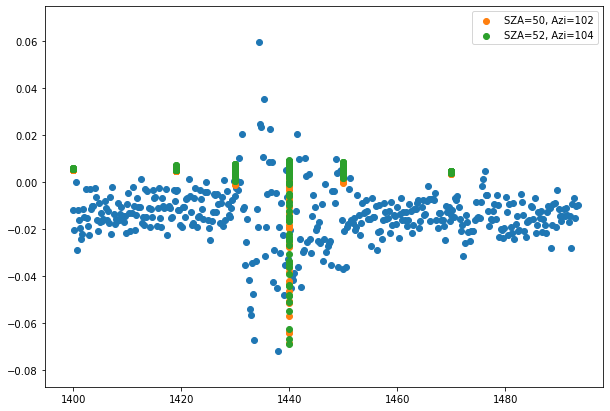

In [80]:
# plot the polarization data at the given geometry
lamb = normdf2['Lambda'].unique()
plt.figure(figsize=[10,7])
#plt.plot(np.linspace(df['w1'].min(),df['w1'].max(),200),ravg,c='k')
plt.scatter(df['w0'],df['pol'])
data = normdf2[(normdf2['CTA(km)']==65.0)&(normdf2['CSH(km)']==4.0)]
plt.scatter(normdf2['Lambda'],normdf2['P'],label='SZA=50, Azi=102')
plt.scatter(normdf['Lambda'],normdf['P'],label='SZA=52, Azi=104')
plt.legend()

### The above example clearly does not show a good agreement with the continuum P... 

### Lets try to see if the trend in P can be explained by a higher haze at higher latitudes...

/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/gouravmahapatr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

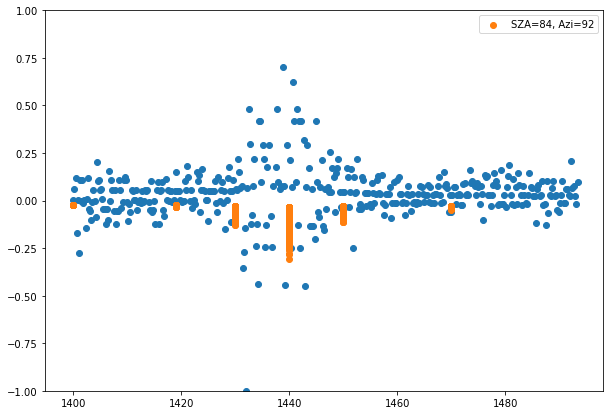

In [95]:
#fnpdf[(fnpdf['lat']>50)&(fnpdf['lat']<52)]
df2 = fnpdf[(fnpdf['orbitnum']==522)&(fnpdf['orbittype']==4)&(fnpdf['ObsvSeq']==138)]
normdf3 = modeldf[(modeldf['theta0']==84)&(modeldf['phi']==92.0)]
normdf3 = get_normdf(normdf3)
# plot the polarization data at the given geometry
lamb = normdf2['Lambda'].unique()
plt.figure(figsize=[10,7])
#plt.plot(np.linspace(df['w1'].min(),df['w1'].max(),200),ravg,c='k')
plt.scatter(df2['w0'],df2['pol'])
plt.ylim([-1,1])
data = normdf3[(normdf3['CTA(km)']==65.0)&(normdf3['CSH(km)']==4.0)]
plt.scatter(normdf3['Lambda'],normdf3['P'],label='SZA=84, Azi=92')
plt.legend()

### Fit the data at lower latitudes purely on the basis of total flux

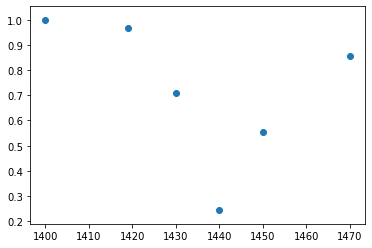

In [109]:
# take an orbit Observation sequence and find the best fit on the basis of minimization of RMSE
# get the unique wavlength points
lamb = modeldf['Lambda'].unique()
# get the normalized TOTAL flux from SPICAV data
fnorm = get_normflux(df,lamb)

plt.scatter(lamb,fnorm)